<a href="https://colab.research.google.com/github/iCTSV-HUST/ictsv-kd-tools/blob/main/GetActivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title ### Edit các thông tin ở đây { display-mode: "form" }
start_id = 14000 # @param {type:"number"}
end_id   = 17000 # @param {type:"number"}

1. Ấn cái icon "chìa khóa" bên trái và thêm/+Add new secret `USER_CODE`, `TOKEN_CODE` (lấy từ UserCode, TokenCode của 1 url ảnh trên ctsv). Kích hoạt Notebook Access. Kết quả sẽ như hình:

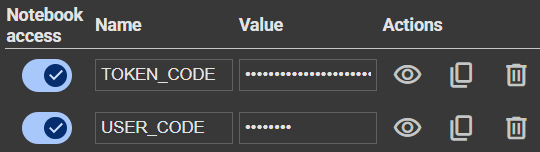

2. Chỉnh id hoạt động bắt đầu, kết thúc: `start_id`, `end_id` ở trên
3. Runtime -> Run all (hoặc Ctrl + F9)
4. Đợi cho chạy xong (5p)
5. Ấn cái icon "folder" bên trái và tải file DanhSachHoatDong.xlsx về

Note: File errors.csv chứa id của hoạt động không lấy đc

### Code chạy

#### Definition

In [ ]:
%pip install html2text

In [ ]:
from google.colab import userdata
CTSVTokenCode = userdata.get('TOKEN_CODE')
CTSVUserNameCode = userdata.get('USER_CODE')

import asyncio
import aiohttp
from aiohttp import ClientSession

connector = aiohttp.TCPConnector(limit_per_host=50)
custom_client = aiohttp.ClientSession(connector=connector)

In [ ]:
import json
import html2text

# HTML to Text conversion
html_converter = html2text.HTML2Text()
html_converter.ignore_images = True
html_converter.unicode_snob = True
html_converter.ignore_links = False

# Error list
errored_list = []

# Process API Response
def process_data(activity_id: int, data):
    if data["RespCode"] == 0:
        activity = data["Activities"][0]
        print(f"GET {activity_id}: {activity['StartTime']} {activity['FinishTime']} {activity['AName']}")
        activity["ADesc"] = html_converter.handle(activity["ADesc"])
        return activity
    else:
        print(f"GET {activity_id} failed: {data['RespCode']} {data['RespText']}")

        # 205 Hoạt động không tồn tại
        if data["RespCode"] != 205:
            errored_list.append(activity_id)

        return None

# Make API Request
async def make_request(session: ClientSession, activity_id: int):
    url = "https://ctsv.hust.edu.vn/api-t/Activity/GetActivityById"
    request_body = {
        "AId": activity_id,
        "TokenCode": CTSVTokenCode,
        "UserName": CTSVUserNameCode
    }

    try:
        async with session.post(url, json=request_body) as response:
            if response.status != 200:
                raise Exception(f"HTTP error! Status: {response.status}")
            data = await response.json()

            return process_data(activity_id, data)
    except Exception as e:
        print(f"Error making request for {activity_id}: {str(e)}")
        return None

# Send Multiple Requests Concurrently
async def send_requests(start_id: int, end_id: int):
    results = []

    async with custom_client as session:
        tasks = [make_request(session, activity_id) for activity_id in range(start_id, end_id + 1)]
        responses = await asyncio.gather(*tasks)

        for response in responses:
            if response is not None:
                results.append(response)

        # Save Results to Files
        with open('results.json', 'w', encoding='utf-8') as f:
            json.dump([activity for activity in results], f, ensure_ascii=False, indent=2)
        print(f"Successfully processed {len(results)} results")

        with open('errors.csv', 'w', encoding='utf-8') as f:
            f.write("\n".join(map(str, errored_list)))
        print(f"Errors written to errors.csv")

    return results

#### Run code

In [ ]:
async with aiohttp.ClientSession() as session:
    test = await make_request(session, 12584)
    if (test == None):
        quit()
        raise Exception("Lỗi Token")

activities = await send_requests(start_id, end_id)


In [ ]:
if(len(activities) == 0):
    raise Exception("EMPTY ACTIVITY LIST. CHECK start_id and end_id.")

### Data Analysis below

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(activities)

In [ ]:
columns_to_remove = ['ACode','GId','AGId','Data','AStatus','UAStatus','ARefId','ACriteriaLst','UserRole','Publish']
df_fixed = df.drop(columns=columns_to_remove)
df_fixed['CriteriaLst'] = df_fixed['CriteriaLst'].apply(lambda criterias: '\n'.join([item['CName'] for item in criterias]))
df_fixed['Link'] = df_fixed['AId'].apply(lambda x: f"https://ctsv.hust.edu.vn/#/hoat-dong/{x}/chi-tiet")

# Reordering
column_order = [
    'AId', 'AName', 'GName','CriteriaLst',
    'CreateDate', 'Deadline', 'Link', 'CreateUser',
    'StartTime', 'FinishTime', 'ADesc', 'APlace',
    'AType', 'AGDesc',
    'Avatar',
]
df_fixed = df_fixed[column_order]

# Rename columns
df_fixed = df_fixed.rename(columns={
    'AName': 'Tên hoạt động',
    'AType': 'Loại HĐ',
    'ADesc': 'Nội dung',
    'StartTime': 'TG bắt đầu',
    'FinishTime': 'TG kết thúc',
    'APlace': 'Địa điểm',
    'GName': 'BTC',
    'Deadline': 'Hạn nộp MC',
    'CriteriaLst': 'DS tiêu chí',
    'CreateDate': 'TG tạo HĐ',
    'CreateUser': 'DS kiến nghị'
})



df_fixed


In [ ]:
df_fixed.to_excel(f"DanhSachHoatDong{start_id}-{end_id}.xlsx", index=False)

In [ ]:
df_fixed.to_csv(f"DanhSachHoatDong{start_id}-{end_id}.csv", index=False)

In [ ]:
df_filtered = df_fixed[df_fixed['BTC'] != "Ban CTSV"]
print(df_filtered.shape)

# Extract AId column to an array
filtered_aid_array = df_filtered['AId'].to_list()